<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec


### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
import zipfile

if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https: // raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip - o songs_dataset.zip
        else:
            !wget songs_dataset.zip https: // github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip

        with zipfile.ZipFile('./songs_dataset.zip') as zip:
            zip.extractall()
else:
    print("El dataset ya se encuentra descargado")


In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")


In [104]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_11304\1070875078.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [105]:
print("Cantidad de documentos:", df.shape[0])


Cantidad de documentos: 1846


### 1 - Preprocesamiento

In [106]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))


In [107]:
# Demos un vistazo
sentence_tokens[:2]


[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

### 2 - Crear los vectores (word2vec)

In [108]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información


class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(
                self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


In [109]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram


In [110]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)


In [111]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)


Cantidad de docs en el corpus: 1846


In [112]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:",
      len(w2v_model.wv.index_to_key))


Cantidad de words distintas en el corpus: 445


### 3 - Entrenar embeddings

In [113]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                total_examples=w2v_model.corpus_count,
                epochs=20,
                compute_loss=True,
                callbacks=[callback()]
                )


Loss after epoch 0: 113208.15625
Loss after epoch 1: 65953.953125
Loss after epoch 2: 65934.265625
Loss after epoch 3: 65711.96875
Loss after epoch 4: 63872.5
Loss after epoch 5: 64142.46875
Loss after epoch 6: 64058.8125
Loss after epoch 7: 64755.4375
Loss after epoch 8: 62585.5625
Loss after epoch 9: 60415.25
Loss after epoch 10: 59823.625
Loss after epoch 11: 58930.1875
Loss after epoch 12: 57726.4375
Loss after epoch 13: 56493.125
Loss after epoch 14: 55842.5625
Loss after epoch 15: 55862.5
Loss after epoch 16: 51695.8125
Loss after epoch 17: 49815.5
Loss after epoch 18: 49568.125
Loss after epoch 19: 48959.75


(156986, 287740)

### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)


In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)


In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["four"], topn=10)


In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["money"], topn=5)


In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["diedaa"])


In [ ]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love)


In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)


In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)


### 5 - Visualizar agrupación de vectores

In [15]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS = 20
# fig = plt.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
# fig.show(renderer="colab") # esto para plotly en colab

fig = plt.figure()
ax = fig.add_subplot()

x = vecs[:MAX_WORDS, 0]
y = vecs[:MAX_WORDS, 1]

labels = labels[:MAX_WORDS]

ax.scatter(x, y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

fig.show()


In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model, 3)

# fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
# fig.update_traces(marker_size = 2)
# fig.show(renderer="colab") # esto para plotly en colab

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = vecs[:MAX_WORDS, 0]
y = vecs[:MAX_WORDS, 1]
z = vecs[:MAX_WORDS, 2]

labels = labels[:MAX_WORDS]

ax.scatter(x, y, z)

for i, txt in enumerate(labels):
    ax.text(x[i], y[i], z[i], txt)

plt.show()


In [ ]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)


### Alumno

- Elegir algún corpus de texto de su preferencia (conviene que sea algo de lo cual ustedes tengan algo de conocimiento al respecto para poder después interpretar la similaridades de embeddings que estudien). Puede ser literatura, texto técnico, blogs, artículos, etc...

Para este desafío se trabajará con un dataset que tienen todos las oraciones de la biblia. Este dataset fue curado utilizando las diferentes versiones de la biblia que provee *ebible.org*. Elijo este dataset porque creo que representa un texto que ha marcado la semántica de muchas culturas, durante largos períodos históricos.

In [60]:
# Descargar la carpeta de dataset
import os
import platform
import zipfile

if os.access('spa-sparvg.txt', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https: // raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt - o spa-sparvg.txt
    else:
        !wget spa-sparvg.txt https: // raw.githubusercontent.com/BibleNLP/ebible/main/corpus/spa-spavbl.txt
else:
    print("El dataset ya se encuentra descargado")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 4100k    0 16384    0     0   6467      0  0:10:49  0:00:02  0:10:47  6478
 90 4100k   90 3698k    0     0  1112k      0  0:00:03  0:00:03 --:--:-- 1114k
100 4100k  100 4100k    0     0  1212k      0  0:00:03  0:00:03 --:--:-- 1214k


In [2]:
import pandas as pd

bible_df = pd.read_csv('./spa-sparvg.txt', sep='/n',
                       quotechar='"', header=None, engine='python')
bible_df.head()


,0
0,"En el principio, Dios creó los cielos y la tie..."
1,La tierra carecía de forma y estaba vacía; la ...
2,Y Dios dijo: “¡Que haya luz!” y hubo luz.
3,"Dios vio que la luz era buena, y separó a la l..."
4,Entonces Dios llamó a la luz “día” y a la oscu...


- Entrenar embeddings con el  corpus elegido utilizando Gensim. Pueden intentar modificar varios parámetros: tipo de modelo (cbow/skipgram), tamaño de vocabulario, tamaño de ventana de contexto, negative samples (que trataremos de hablar algo porque no hubo tiempo la vez pasada).

In [3]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

bible_sentence_tokens = []
for _, row in bible_df[:None].iterrows():
    bible_sentence_tokens.append(text_to_word_sequence(row[0]))


In [4]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información


class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()

        loss_to_print = loss if self.epoch == 0 else (
            loss - self.loss_previous_step)
        print('Model {} loss after epoch {}: {}'.format(
            str(model), self.epoch, loss_to_print))

        self.epoch += 1
        self.loss_previous_step = loss


In [5]:
from gensim.models import Word2Vec

MAX_WORKERS = 10

def createModelAndTrain(model_config, epochs):

    w2v_model = Word2Vec(min_count=model_config['min_count'],
                         window=model_config['window'],
                         vector_size=model_config['vector_size'],
                         negative=model_config['negative'],
                         workers=MAX_WORKERS,
                         sg=model_config['sg'])

    w2v_model.build_vocab(bible_sentence_tokens)

    w2v_model.train(bible_sentence_tokens,
                    total_examples=w2v_model.corpus_count,
                    compute_loss=True,
                    epochs=epochs)

    return w2v_model


In [6]:
TRAIN_EPOCHS = 50

proposed_model_configs = [
    {'min_count': 5, 'window': 3, 'vector_size': 300, 'negative': 20, 'sg': 0},
    {'min_count': 5, 'window': 3, 'vector_size': 500, 'negative': 20, 'sg': 0},
    {'min_count': 5, 'window': 3, 'vector_size': 200, 'negative': 20, 'sg': 1},
    {'min_count': 5, 'window': 3, 'vector_size': 200, 'negative': 30, 'sg': 0},
    {'min_count': 5, 'window': 5, 'vector_size': 300, 'negative': 20, 'sg': 0},
    {'min_count': 20, 'window': 5, 'vector_size': 150, 'negative': 20, 'sg': 1}]

trained_models = []
for proposed_model_config in proposed_model_configs:
    print('-------Starting a new WORD2VEC model training--------')
    print('Training params:', proposed_model_config)

    trained_model = createModelAndTrain(proposed_model_config, TRAIN_EPOCHS)
    trained_models.append(trained_model)

    print('-------NEW WORD2VEC MODEL TRAINED--------')
    print('Training loss:', trained_model.get_latest_training_loss())

-------Starting a new WORD2VEC model training--------
Training params: {'min_count': 5, 'window': 3, 'vector_size': 300, 'negative': 20, 'sg': 0}
-------NEW WORD2VEC MODEL TRAINED--------
Training loss: 5315460.0
-------Starting a new WORD2VEC model training--------
Training params: {'min_count': 5, 'window': 3, 'vector_size': 500, 'negative': 20, 'sg': 0}
-------NEW WORD2VEC MODEL TRAINED--------
Training loss: 5411646.5
-------Starting a new WORD2VEC model training--------
Training params: {'min_count': 5, 'window': 3, 'vector_size': 200, 'negative': 20, 'sg': 1}
-------NEW WORD2VEC MODEL TRAINED--------
Training loss: 21462632.0
-------Starting a new WORD2VEC model training--------
Training params: {'min_count': 5, 'window': 3, 'vector_size': 200, 'negative': 30, 'sg': 0}
-------NEW WORD2VEC MODEL TRAINED--------
Training loss: 5891037.5
-------Starting a new WORD2VEC model training--------
Training params: {'min_count': 5, 'window': 5, 'vector_size': 300, 'negative': 20, 'sg': 0}
-

In [7]:
import pickle
pickle.dump(trained_models, open('trained_models.p', 'wb'))

In [ ]:
trained_models = pickle.load(open('trained_models.p', 'rb'))

Como se acaba de mostrar, se entrenaron distintos modelos con diferentes hiperparámetros. En los resultados se puede ver que el modelo que mejor performa es el primero, el cuál tiene la siguiente configuración:
- min_count = 5
- window = 3
- vector_size = 300
- negative = 20
- sg = 0

Luego de obtener estos hiperparámetros, se desarrolló un nuevo código para hacer una optimización uilizando un framework de optimización de hiperparámetros llamado Optuna. Sin embargo, los resultados obtenidos no fueron mejores que eligiendo algunos conjúntos de parámetros de forma manual. De todas maneras, se dejan las celdas que muestran el trabajo realizado (lamentablemente los resultados de la optimización fueron borrados)

In [12]:
import optuna

trialsModels = []


def createModelAndTrain(min_count, window, vector_size, negative,
                        workers, sg, epochs):

    w2v_model = Word2Vec(min_count=min_count, window=window,
                         vector_size=vector_size, negative=negative,
                         workers=workers, sg=sg)

    w2v_model.build_vocab(bible_sentence_tokens)

    w2v_model.train(bible_sentence_tokens,
                    total_examples=w2v_model.corpus_count,
                    compute_loss=True,
                    epochs=epochs)

    return w2v_model


def objective(trial):
    min_count = 5
    
    window = trial.suggest_int('window', 2, 4)
    vector_size = trial.suggest_int('vector_size', 200, 500)
    negative = trial.suggest_int('negative', 15, 25)
    
    workers = 1
    
    sg = trial.suggest_categorical('sg', [0, 1])

    epochs = trial.suggest_int('epochs', 20, 50)

    w2v_model = createModelAndTrain(min_count, window, vector_size,
                                    negative, workers, sg, epochs)

    trialsModels.append(w2v_model)

    return w2v_model.get_latest_training_loss()


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
study.best_params

- Con alguna de versión de embeddigns que hayan entrenado (o con todas!) estudiar similaridades de términos que crean interesantes. Graficarlos en 2D y si quieren en 3D y destacar casos interesantes para su corpus. Interpretarlos del conocimiento a priori que tengan del corpus.

Antes de empezar con el análisis, se presentan algunas funciones que fueron desarrolladas con el fin de investigar el subespacio vectorial de los vectores que representan las palabras del corpus, obtenido con algunos de los modelos entrenados. Una de las funciones principales que se desarrolló es *findNearestRelatedWordByRelation*. A esta función se le puedn pasar dos palabras que permitan generar un vector relación, el cuál se obtiene haciendo la diferencia entre las dos representaciones vectoriales de las palabras, y una palabra de referencia cuyo vector asociado, será utilizado como orígen para sumarle la relación y observar a dónde nos lleva dicha relación, desde esa referencia. El lugar a dónde nos lleva la relación desde la referencia quedará determinado por el vector más cercano al destino alcanzado por la suma referencia más relación. El objetivo final de esta función es chequear si existe algún vector de concepto, tal como el género.
La otra función a destacar es *chainOfRelations*. Esta función recibe una palabra de inicio y va buscando recursivamente las palabras con mayor similaridad. Repite este proceso hasta llegar a la palabra de orígen o hasta alcanzar la máxima profundidad establecida.

In [54]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def word2Vector(model, word):
    return model.wv.vectors[model.wv.key_to_index[word]]

def findNearestWordInRelation(model, relation_vector, reference_word):
    reference_vector = word2Vector(model, reference_word)
    diffs = (reference_vector + relation_vector) - model.wv.vectors
    modules = np.linalg.norm(diffs, axis=1)
    nearest_word = model.wv.index_to_key[np.argmin(modules, axis=0)]

    if nearest_word == reference_word:
        print('There is not a word nearer than the reference word')
    else:
        return nearest_word

def findNearestRelatedWordByRelation(model, start_word, end_word, reference_word):
    relation = word2Vector(model, end_word) - word2Vector(model, start_word)
    return findNearestWordInRelation(model, relation, reference_word)

def chainOfRelations(model, start_word, max_depth=20):
    results = [start_word]
    next_word = start_word
    for i in range(max_depth):        
        next_word, similarity = model.wv.most_similar(positive=[next_word], topn=1)[0]
        if next_word in results:
            return results
        else:
            results.append(next_word)
    

A cotinuación, se van a hacer algunos análisis con el mejor modelo entrenado.

In [9]:
best_w2v_model = trained_models[0]

In [72]:
best_w2v_model.wv.most_similar(positive=["placer"], topn=10)

[('beneficio', 0.3947082757949829),
 ('fruto', 0.3788556754589081),
 ('podrás', 0.3546346426010132),
 ('cultivar', 0.3522382378578186),
 ('producirán', 0.33700793981552124),
 ('aroma', 0.33690667152404785),
 ('cosecharán', 0.3368656635284424),
 ('discernimiento', 0.3327734172344208),
 ('proceso', 0.32270705699920654),
 ('demuestre', 0.3190402686595917)]

En este primer análisis de similaridad me hace reflexionar sobre cómo, en este corpus, para correcto afirmar que semánticamente el placer no está relacionado con el cuerpo o la sexualidad. Aparece el *beneficio* como primer elemento similar y luego *fruto*, que en algún punto está relacionado a *cultivar* y *producirán*.

In [79]:
best_w2v_model.wv.most_similar(positive=["beneficio"], topn=10)

[('defecto', 0.4603940546512604),
 ('problema', 0.44296109676361084),
 ('alguno', 0.4190731644630432),
 ('motivo', 0.41209250688552856),
 ('duda', 0.4117620885372162),
 ('apoyo', 0.40760889649391174),
 ('placer', 0.3947083055973053),
 ('crédito', 0.39363062381744385),
 ('sentido', 0.3753696084022522),
 ('interés', 0.37494444847106934)]

Por otro lado, el beneficio parece estar relacionado con *defecto* o *problema*. Tal vez puede leerse con que beneficiarse es está visto como un defecto o un problema. Si volvemos para atrás con nuestro análisis, podríamos decir (no sin que se nos pidan argumentos más fuertes que los mostrados) que el *placer* es un *defecto* o un *problema* desde la semántica de este corpus.

In [27]:
chainOfRelations(best_w2v_model, 'cristo')

['cristo', 'jesucristo', 'dios’', 'dios”', 'dios']

Me resulta interesante ver la circularidad del significado de *dios*. Si bien habrá otras similaridades que acá no se ven, creo que lo que se ve no es una cadena de relaciones semánticas sino una cadena de sinónimos.  

In [28]:
chainOfRelations(best_w2v_model, 'placer')

['placer', 'beneficio', 'apoyo', 'siclos', 'pesaba']

Aá volvemos a ver como existe una cadena de significados que relacionan el placer con el beneficio, específicamente con el dinero. Descubrí que el *Siclo* "... es una antigua unidad monetaria y de peso utilizada en el Oriente Próximo y en Mesopotamia." [Wikipedia]

In [74]:
best_w2v_model.wv.most_similar(positive=["pecador"], topn=10)

[('perro', 0.49850600957870483),
 ('pobre', 0.3968130648136139),
 ('susurro', 0.3930138349533081),
 ('ciervo', 0.38576167821884155),
 ('burlador', 0.38448718190193176),
 ('beso', 0.3811718821525574),
 ('gusano', 0.37955302000045776),
 ('ladrón', 0.379283607006073),
 ('animal', 0.37586063146591187),
 ('acto', 0.37455666065216064)]

In [29]:
chainOfRelations(best_w2v_model, 'pecador')

['pecador', 'perro', 'pájaro']

No termino de entender bien por qué *pecador* esta relacionado en primer lugar a *perro*. Sin embargo, resulta muy particular la relación de *pecador* con *pobre*. Desde mi conocimiento a priori del corpus, esta relación no es real.

In [65]:
best_w2v_model.wv.most_similar(positive=['maldad'], topn=10)

[('violencia', 0.5362457036972046),
 ('rebeldía', 0.47371798753738403),
 ('naturaleza', 0.4467545449733734),
 ('inmoralidad', 0.43959736824035645),
 ('brujería', 0.4392302334308624),
 ('culpa', 0.43859392404556274),
 ('jactancia', 0.43404364585876465),
 ('hostilidad', 0.43217140436172485),
 ('arrogancia', 0.4134955406188965),
 ('miseria', 0.40984609723091125)]

In [75]:
findNearestRelatedWordByRelation(best_w2v_model, 'la', 'las', 'mujer')

There is not a word nearer than the reference word


In [67]:
findNearestRelatedWordByRelation(best_w2v_model, 'rey', 'reina', 'maría')

There is not a word nearer than the reference word


In [68]:
findNearestRelatedWordByRelation(best_w2v_model, 'hombre', 'mujer', 'mujeres')

There is not a word nearer than the reference word


Lamentablemente en los ejemplos citados no se pudieron encontrar vectores de conceptos. Esto no implica que el modelo no contenga alguno o algunos.

Se aplican ahora los estudios al segundo mejor modelo entrenado.

In [23]:
second_best_w2v_model = trained_models[1]

In [25]:
chainOfRelations(second_best_w2v_model, 'amor')

['amor', 'bondad', 'fidelidad', 'inefable', 'confiable']

In [76]:
best_w2v_model.wv.most_similar(positive=['hombre'], topn=10)

[('hombre”', 0.5075526237487793),
 ('fariseo', 0.49650827050209045),
 ('levita', 0.46902525424957275),
 ('niño', 0.4587970972061157),
 ('ladrón', 0.4384770691394806),
 ('granjero', 0.424030601978302),
 ('profeta', 0.4203355610370636),
 ('milagro', 0.4156551659107208),
 ('acto', 0.41405224800109863),
 ('ídolo', 0.4052458107471466)]

In [78]:
chainOfRelations(second_best_w2v_model, 'hombre')

['hombre', 'hombre”']

In [77]:
best_w2v_model.wv.most_similar(positive=['mujer'], topn=10)

[('viuda', 0.5723856091499329),
 ('esposa', 0.5245794057846069),
 ('prostituta', 0.5072476267814636),
 ('mujer”', 0.44288548827171326),
 ('oveja', 0.43697062134742737),
 ('secreción', 0.4369061589241028),
 ('obligación', 0.43553075194358826),
 ('persona', 0.423968106508255),
 ('paloma', 0.41715535521507263),
 ('rut', 0.41298598051071167)]

In [79]:
chainOfRelations(second_best_w2v_model, 'mujer')

['mujer', 'viuda']

En los dos ejemplos anteriores, vemos curiosas asociaciones entre las palabras *hombre* y *mujer*. Por un lado, en la cadena de relaciones encontramos que el término *hombre* se asocia primeramente a sí mismo y también con atributos o adjetivos relacionados a actividades sociales. Por otro, el término *mujer* se relaciona con la viudés y también con la relación marital, es decir, el término *esposa*. Esto es interesante para mí, porque da una idea de que en el contexto de este corpus, la mujer está definida en función de la existencia de un esposo o en la muerte del mismo.

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

import numpy as np


def reduce_dimensions(word_model, num_dimensions=2, algorithm='tsne'):

    vectors = np.asarray(word_model.wv.vectors)
    labels = np.asarray(word_model.wv.index_to_key)

    if algorithm == 'tsne':
        model = TSNE(n_components=num_dimensions, random_state=0)
    else:
        model = IncrementalPCA(n_components=num_dimensions)

    vectors = model.fit_transform(vectors)

    return vectors, labels

In [105]:
def plot2dData(_2d_vecs, _2d_labels, n_words):
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot()

    x = _2d_vecs[:n_words, 0]
    y = _2d_vecs[:n_words, 1]

    labels = _2d_labels[:n_words]

    ax.scatter(x, y)

    for i, txt in enumerate(labels):
        ax.annotate(txt, (x[i], y[i]))

    fig.show()

In [101]:
_2d_tsne_vecs, _2d_tsne_labels = reduce_dimensions(best_w2v_model)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_2456\3467139251.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


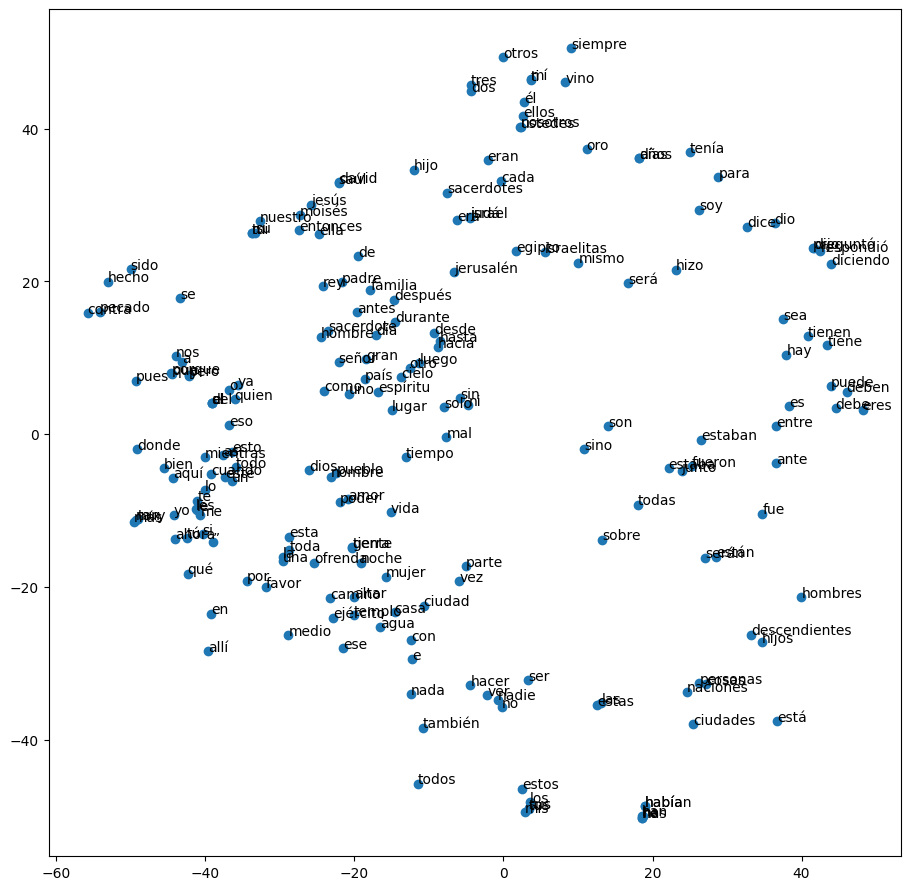

In [110]:
MAX_WORDS = 200
plot2dData(_2d_tsne_vecs, _2d_tsne_labels, MAX_WORDS)

In [107]:
_2d_pca_vecs, _2d_pca_labels = reduce_dimensions(best_w2v_model, algorithm='pca')

C:\Users\Lucas\AppData\Local\Temp\ipykernel_2456\3467139251.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


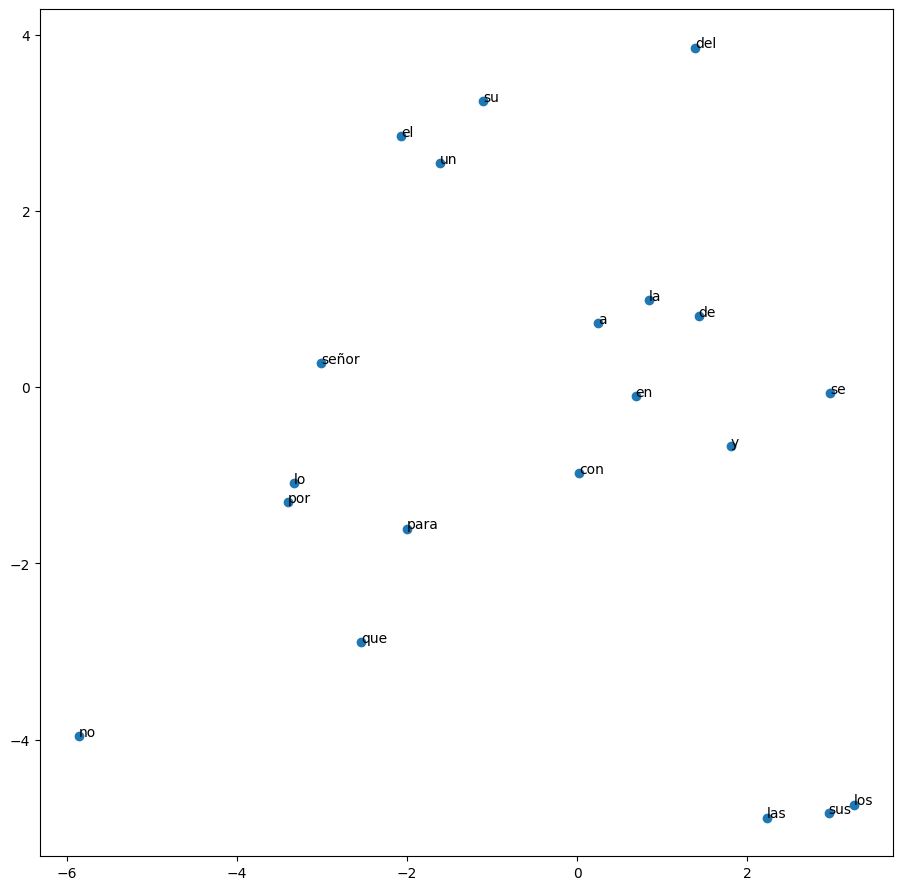

In [108]:
MAX_WORDS = 20
plot2dData(_2d_pca_vecs, _2d_pca_labels, MAX_WORDS)

Respecto a estas representaciones reducidas en dimensionalidad, primero creo que resulta interesante señalar que con relación a PCA, TSNE parece realizar una transoformación que permite visualizar más facilmente algunos clústers de términos.
Por otro lado, en el plot logrado con TSNE, se puede ver un clúster muy claro con los términos *él*, *ellos*, *ustedes*. Me parece una asociación interesante respecto a que tal vez el corpus no trata estos pronombres de forma muy distinta. Quizás esto radique en la universalidad con la que está dado el mensaje de quién el corpus describe como *Dios* o *Jesucrísto*. También hay un clúster interesante con términos *personas* y *naciones*. Nuevamente esto podría estar relacionado con la universalidad del mensaje.

In [ ]:
def plot3dData(_3d_vecs, _3d_labels, n_words):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    x = _3d_vecs[:MAX_WORDS, 0]
    y = _3d_vecs[:MAX_WORDS, 1]
    z = _3d_vecs[:MAX_WORDS, 2]

    labels = _3d_labels[:MAX_WORDS]

    ax.scatter(x, y, z)

    for i, txt in enumerate(labels):
        ax.text(x[i], y[i], z[i], txt)

    plt.show()

In [ ]:
_3d_tsne_vecs, _3d_tsne_labels = reduce_dimensions(best_w2v_model, 3)

Lamentablemente no pude hacer la prueba con la representación en tres dimensiones. Estuve esperando a que se haga la reducción por más de 30 minutos y temía que deje de funcionar el VS Code.